In [176]:
import gym
import time
import torch
from torch import nn
import numpy as np
import copy
import random as rd
import matplotlib.pyplot as plt

# Understanding the environment

In [34]:
env = gym.make('Amidar-ram-v0')
env.reset()

for i_episode in range(1):
    observation = env.reset()
    for t in range(1000):
        time.sleep(0.02)
        env.render()
        action = env.action_space.sample()
        observation, reward, done, info = env.step(action)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
env.close()

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


KeyboardInterrupt: 

In [23]:
env.action_space

Discrete(10)

In [12]:
env.observation_space

Box(0, 255, (128,), uint8)

In [18]:
env.observation_space.low

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8)

# Deep Q Network

> https://towardsdatascience.com/qrash-course-deep-q-networks-from-the-ground-up-1bbda41d3677

> https://www.analyticsvidhya.com/blog/2019/04/introduction-deep-q-learning-python/

In [179]:
class DeepQNet(nn.Module):

    def __init__(self, hidden_size=128):
        super(DeepQNet, self).__init__()
        self.state_space_size = 128
        self.action_space_size = 10
        self.hidden_size = hidden_size
        

        self.mlp = nn.Sequential(
            nn.Linear(self.state_space_size, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.hidden_size//2),
            nn.ReLU(),
            nn.Linear(self.hidden_size//2, self.action_space_size)
        )
        
    def forward(self, x):
        return self.mlp(x)

    
net = DeepQNet()
print(net)

DeepQNet(
  (mlp): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
)


In [180]:
class Agent():
    def __init__(self, net, policy="epsilon-greedy", discount=0.9, epsilon=0.8, batch_size=8, C=32):
        """
        net: network that goes from the state space to the action space
        discount: discount factor in the bellman equation
        epsilon: epsilon factor for the epsilon greedy policy
        C: number of iterations before updating the target network and copying the weights of the current network (for convergence stability)
        """
        self.net = net
        self.target_net = copy.deepcopy(net)
        
        self.policy = policy
        self.discount = discount
        self.epsilon = epsilon
        self.batch_size = batch_size
        self.C = C
        
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=1e-4)
        self.loss = nn.MSELoss()
        self.replay_buffer = []
        self.iteration = 0

        
    def act(self, observation):
        observation = torch.Tensor(observation)
        q = self.net(observation)
        if self.policy == "greedy":
            return torch.argmax(q).item()
        
        elif self.policy == "epsilon-greedy":
            if np.random.random() > self.epsilon:
                return np.random.randint(self.net.action_space_size)
            return torch.argmax(q).item()
        
        else:
            raise BaseException("Not implemented yet.")
        
    def learn(self, previous_observation, action, reward, observation):
        self.replay_buffer.append((previous_observation, action, reward, observation))
        
        if len(self.replay_buffer) < self.batch_size:
            return
        
        if self.iteration >= self.C:
            """
            Update target network
            """
            self.target_net = copy.deepcopy(net)
            self.iteration = 0
        
        samples = rd.sample(self.replay_buffer, self.batch_size)
        previous_observations = torch.cat([torch.Tensor(previous_observation).view(1,-1) for previous_observation,_,_,_ in samples])
        observations = torch.cat([torch.Tensor(observation).view(1,-1) for _,_,_,observation in samples])
        rewards = torch.Tensor([reward for _,_,reward,_ in samples])

        q = self.net(previous_observations)
        q = torch.Tensor([q[i,action] for i, (_,action,_,_) in enumerate(samples)])
        loss = self.loss(q, rewards + self.discount * torch.max(self.target_net(observations), axis=1).values)
            
        self.net.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.iteration += 1
    
agent = Agent(net)

Episode finished after 722 timesteps
Episode finished after 729 timesteps
Episode finished after 729 timesteps
Episode finished after 828 timesteps
Episode finished after 734 timesteps
Episode finished after 792 timesteps
Episode finished after 840 timesteps
Episode finished after 796 timesteps
Episode finished after 716 timesteps
Episode finished after 761 timesteps
Episode finished after 813 timesteps
Episode finished after 736 timesteps
Episode finished after 873 timesteps
Episode finished after 804 timesteps
Episode finished after 846 timesteps
Episode finished after 732 timesteps
Episode finished after 723 timesteps
You won!
You won!
Episode finished after 720 timesteps


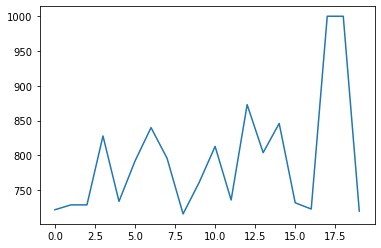

In [181]:
env = gym.make('Amidar-ram-v0')
env.reset()

n_episodes = 20
n_steps_max = 1000
scores = []

for i_episode in range(n_episodes):
    observation = env.reset()
    for t in range(n_steps_max):
        # env.render()
        action = agent.act(observation)
        previous_observation = observation
        observation, reward, done, info = env.step(action)
        agent.learn(previous_observation, action, reward, observation)
        
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            scores.append(t+1)
            break
        
    if not done:
        print("You won!")
        scores.append(n_steps_max)
        
env.close()
plt.plot(scores)

# Pistes

> Implémenter UCB plutôt qu'epsilon greedy

> Hyperoptimisation (learning rate, architecture, epsilon, discount)

> Plus d'épisodes